In [108]:
import os
import numpy as np
from pkg_resources import resource_filename
import astropy.units as u
from dsacalib.routines import get_files_for_cal, calculate_sefd, calibrate_measurement_set
from dsacalib.plotting import summary_plot
from dsacalib.calib import apply_calibration_tables
from casacore.tables import table
import casatools as cc
#import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
# Measure SEFD per antenna, polarization for a small (t_obs~15 min) measurement set 
# from the commissioning data (12 Apr 2021).
# We follow 'SEFD_template.ipnyb' in /user/proj/prototype/dsa-notebooks
# Parameters that may need to be changed

date = '2021-04-13'
duration = 11.5*u.min # The length of the measurement set created, centered on the calibrator transit
refant = '102'
#calname = 'J013741+330935' # aka 3C48
calname = 'J052109+163822' # aka 3C138

# Parameters that are mostly constant
calsources = resource_filename('dsacalib', '3c138_BU.csv')
refcorr = '01'
filelength = 11.5*u.min
msdir = '/mnt/data/dsa110/calibration/'
hdf5dir = '/mnt/data/dsa110/correlator/'
date_specifier = '{0}*'.format(date)

msname = '{0}/{1}_{2}'.format(msdir, date, calname)

# Get a list of the files for each calibrator
filenames = get_files_for_cal(
    calsources,
    refcorr,
    duration,
    filelength,
    date_specifier=date_specifier,
)
cal = filenames[date][calname]['cal']

In [110]:
with table('{0}.ms'.format(msname), readonly=False) as tb:
        model = np.array(tb.MODEL_DATA[:])
        if not os.path.exists('{0}.ms/model.npz'.format(msname, model)):
            np.savez('{0}.ms/model'.format(msname), model)
        tb.putcol('MODEL_DATA', np.ones(model.shape, model.dtype))

Successful read/write open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows


In [111]:
with table('{0}.ms/SPECTRAL_WINDOW'.format(msname)) as tb:
    fobs = (np.array(tb.CHAN_FREQ[:])/1e9).squeeze()

Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows


In [113]:
status = calibrate_measurement_set(
    msname,
    filenames[date][calname]['cal'],
    refant=refant,
    bad_antennas= None, #['103', '116'],
    bad_uvrange='2~27m',
    forsystemhealth=True
)

entered calibration
removing files
flagging of ms data
resetting flags
flagging baselines
flagging zeros
flagging antennas
flagging rfi
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/FIELD: 9 columns, 1 rows
Successful read/write open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
delay cal
flagging based on delay cal
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2kcal: 13 columns, 1404 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_kcal: 13 colum

Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2kcal: 13 columns, 1404 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_bcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2gcal: 13 columns, 2808 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 colu

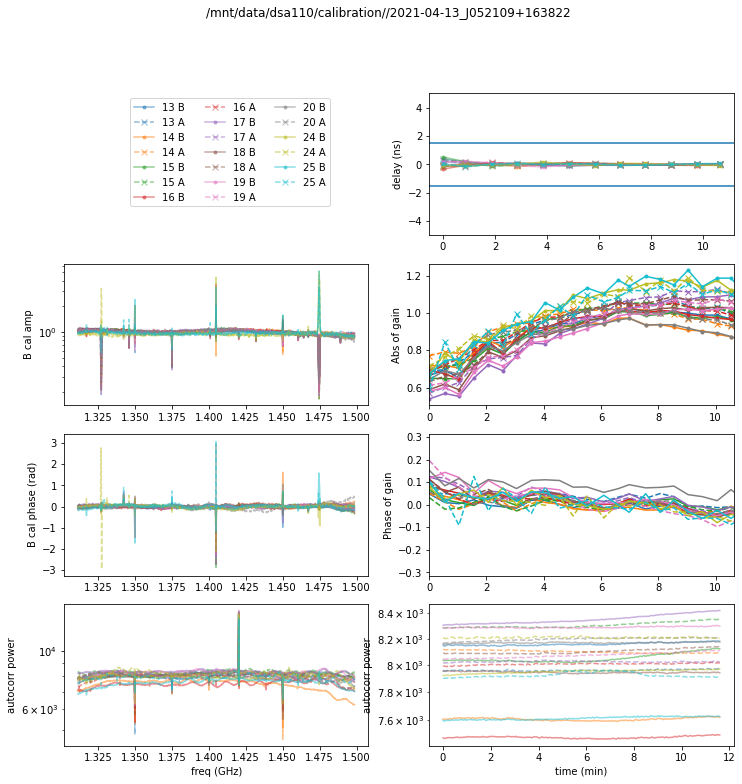

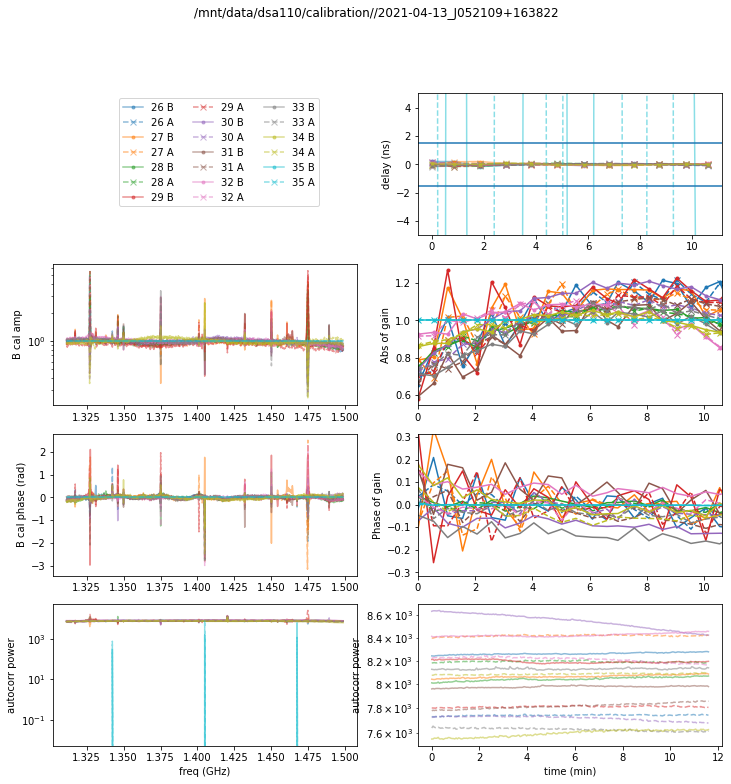

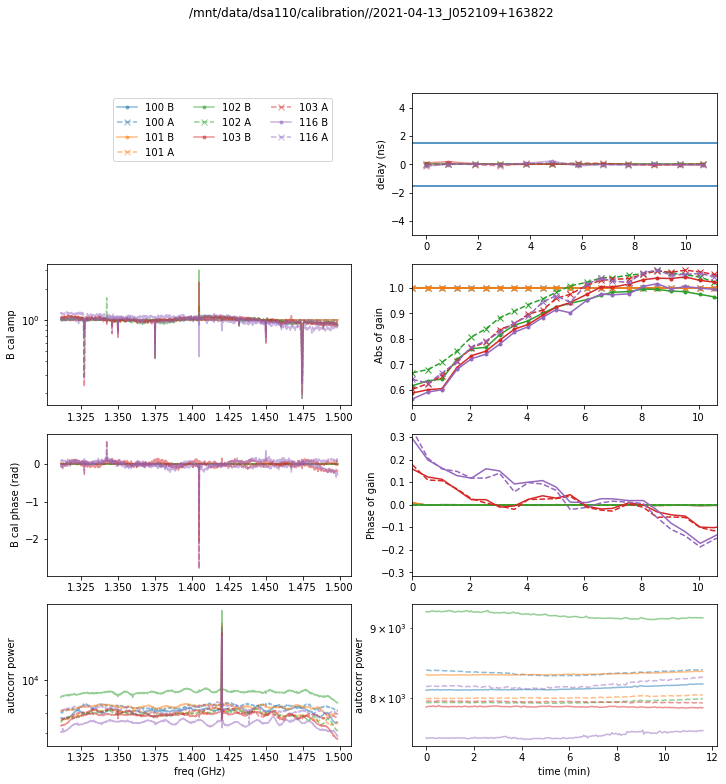

In [114]:
antennas = [13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29,
            30, 31, 32, 33, 34, 35, 100, 101, 102, 103, 116]
for j in range(len(antennas)//10+1):
    summary_plot(
        msname,
        calname,
        2,
        ['B', 'A'],
        antennas[j*10:(j+1)*10]
    )

In [115]:
caltables = [
    {
        'table': '{0}_{1}_kcal'.format(msname, calname),
        'type': 'K', 
        'spwmap': [-1]
    },
    {
        'table': '{0}_{1}_bcal'.format(msname, calname),
        'type': 'B', 
        'spwmap': [-1]
    }
]

In [116]:
cb = cc.calibrater()
cb.open('{0}.ms'.format(msname))
apply_calibration_tables(cb, caltables)

0

In [117]:
cb.setsolve(
    type='G',
    combine='scan, field, obs',
    table='{0}_{1}_2gcal'.format(msname, calname),
    t='30s',
    refant=refant,
    apmode='ap'
)
cb.solve()

True

In [24]:
fobs.shape[0]/4

192.0

0
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2gcal: 13 columns, 2808 rows


/home/user/proj/dsa110-shell/dsa110-calib/dsacalib/routines.py:701: RuntimeWarning: Mean of empty slice
  gain = np.abs(np.nanmean(gain, axis=2)).squeeze(axis=2)


1
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2gcal: 13 columns, 2808 rows


/home/user/proj/dsa110-shell/dsa110-calib/dsacalib/routines.py:701: RuntimeWarning: Mean of empty slice
  gain = np.abs(np.nanmean(gain, axis=2)).squeeze(axis=2)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input

2
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2gcal: 13 columns, 2808 rows


/home/user/proj/dsa110-shell/dsa110-calib/dsacalib/routines.py:701: RuntimeWarning: Mean of empty slice
  gain = np.abs(np.nanmean(gain, axis=2)).squeeze(axis=2)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input

3
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms: 26 columns, 70525 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822.ms/FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2021-04-13_J052109+163822_J052109+163822_2gcal: 13 columns, 2808 rows


/home/user/proj/dsa110-shell/dsa110-calib/dsacalib/routines.py:701: RuntimeWarning: Mean of empty slice
  gain = np.abs(np.nanmean(gain, axis=2)).squeeze(axis=2)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input

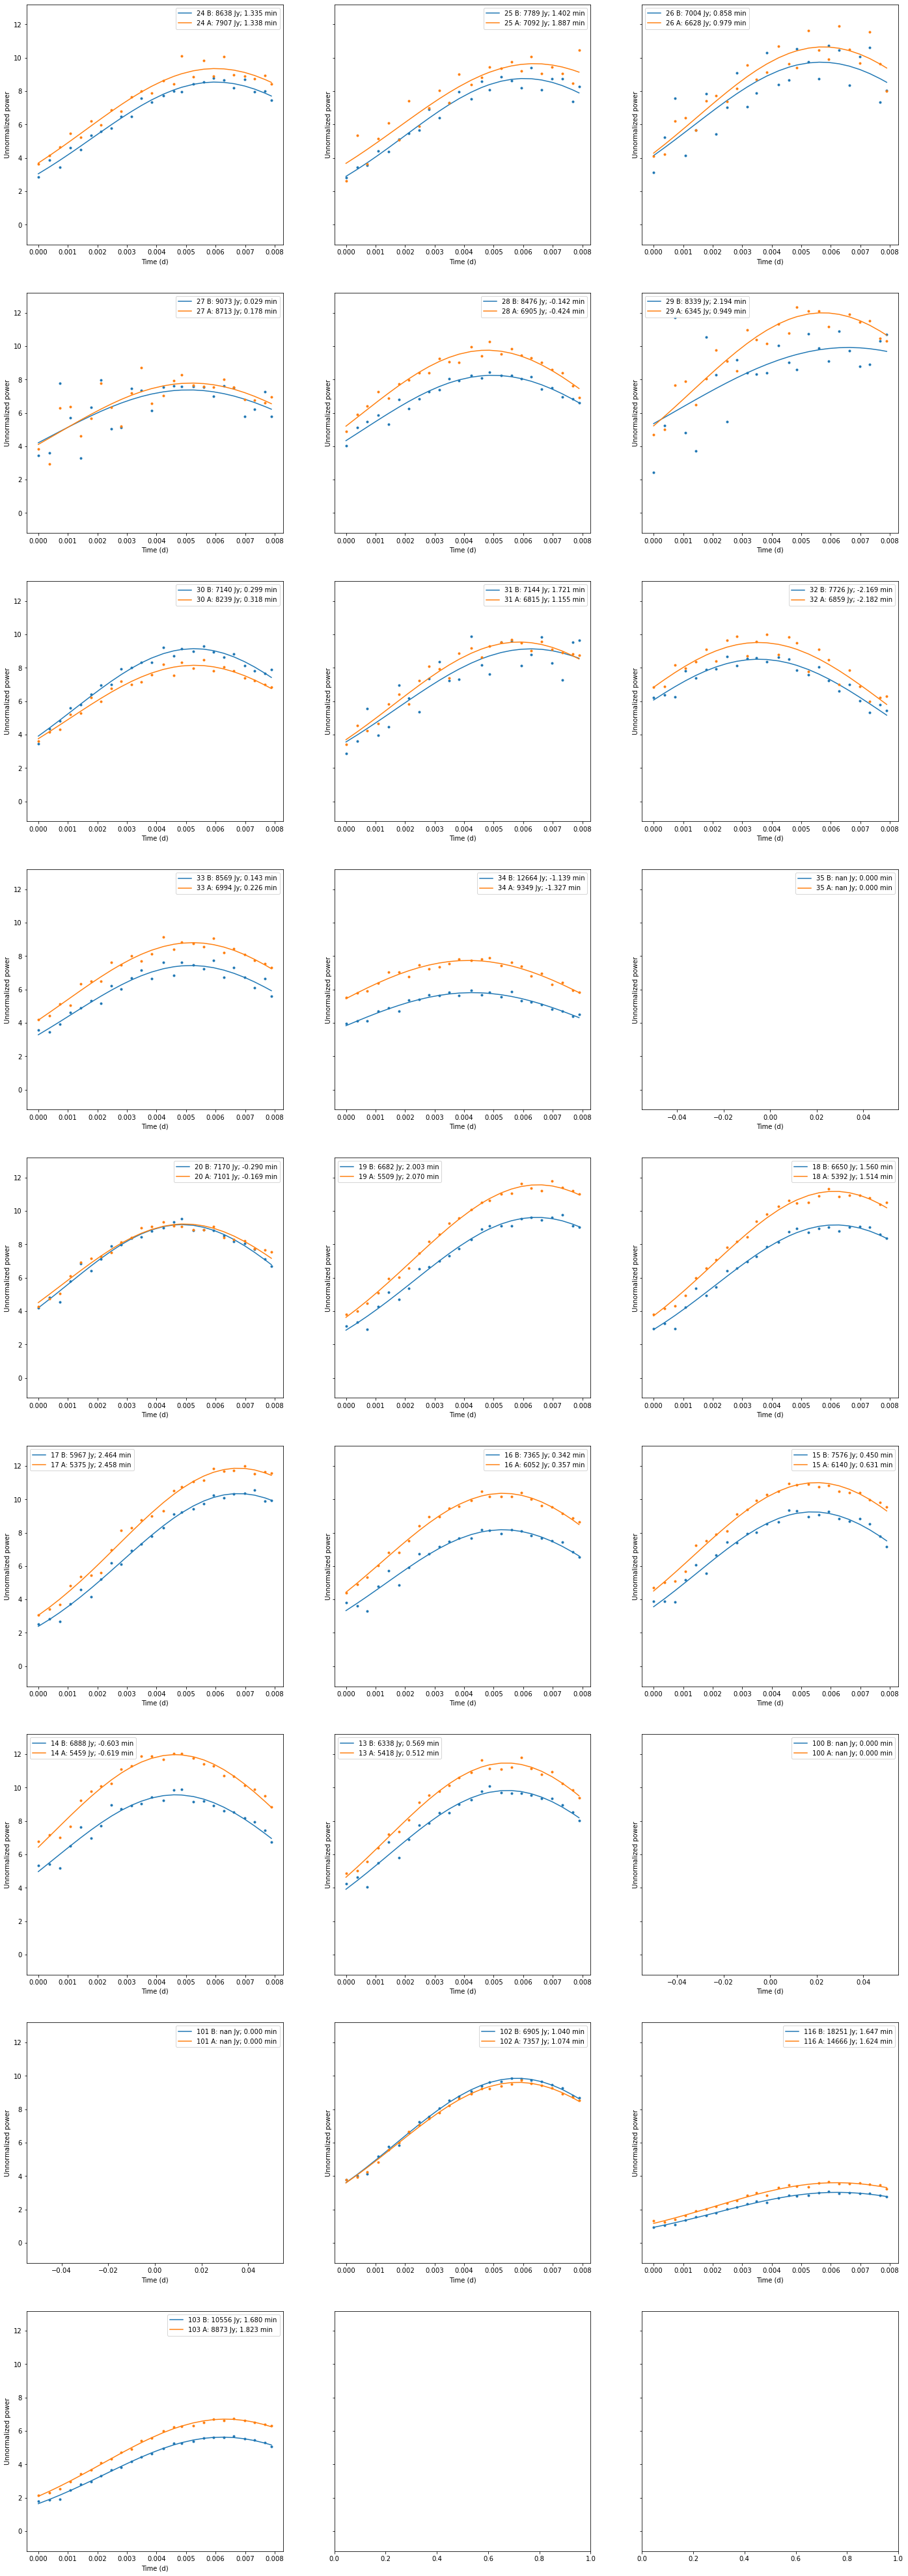

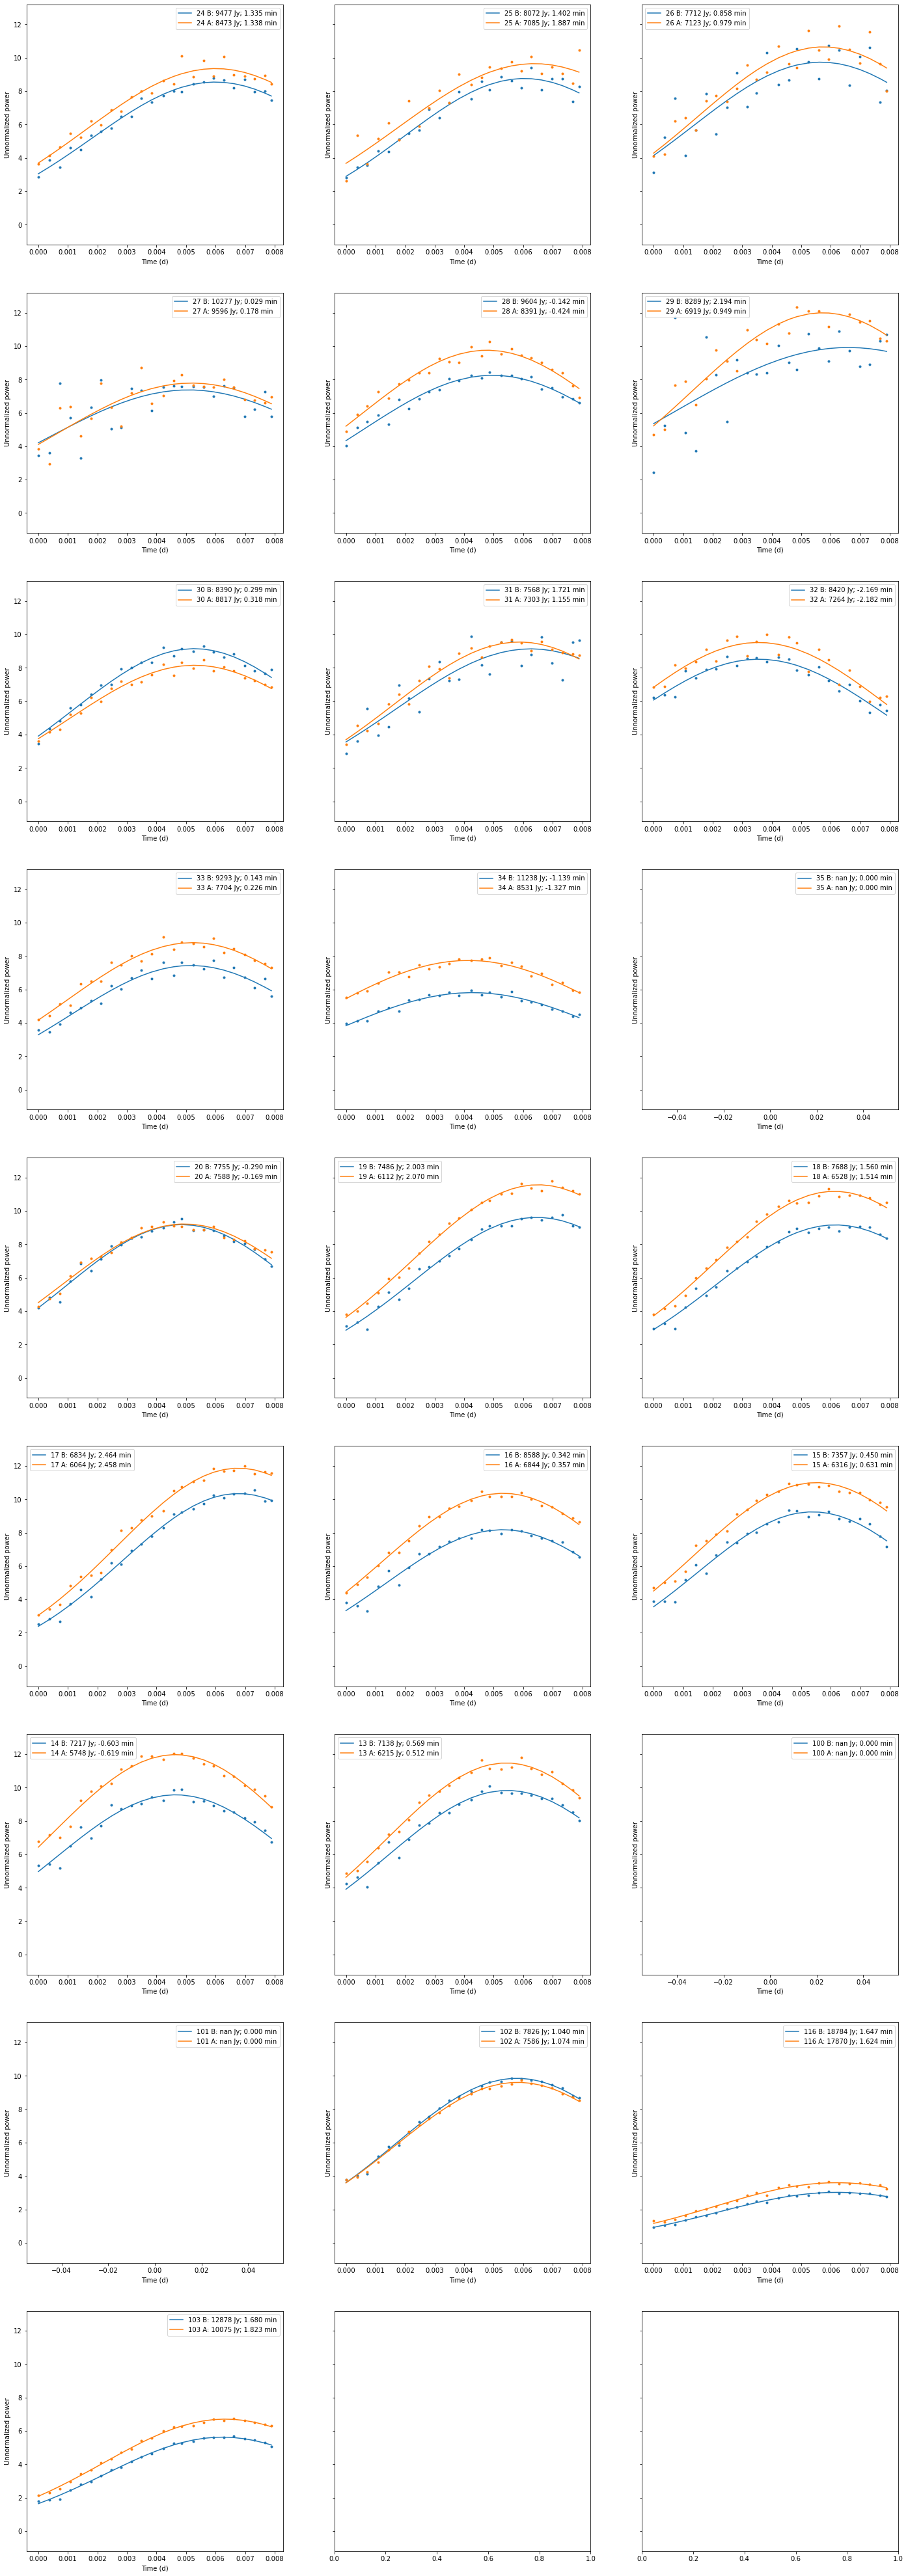

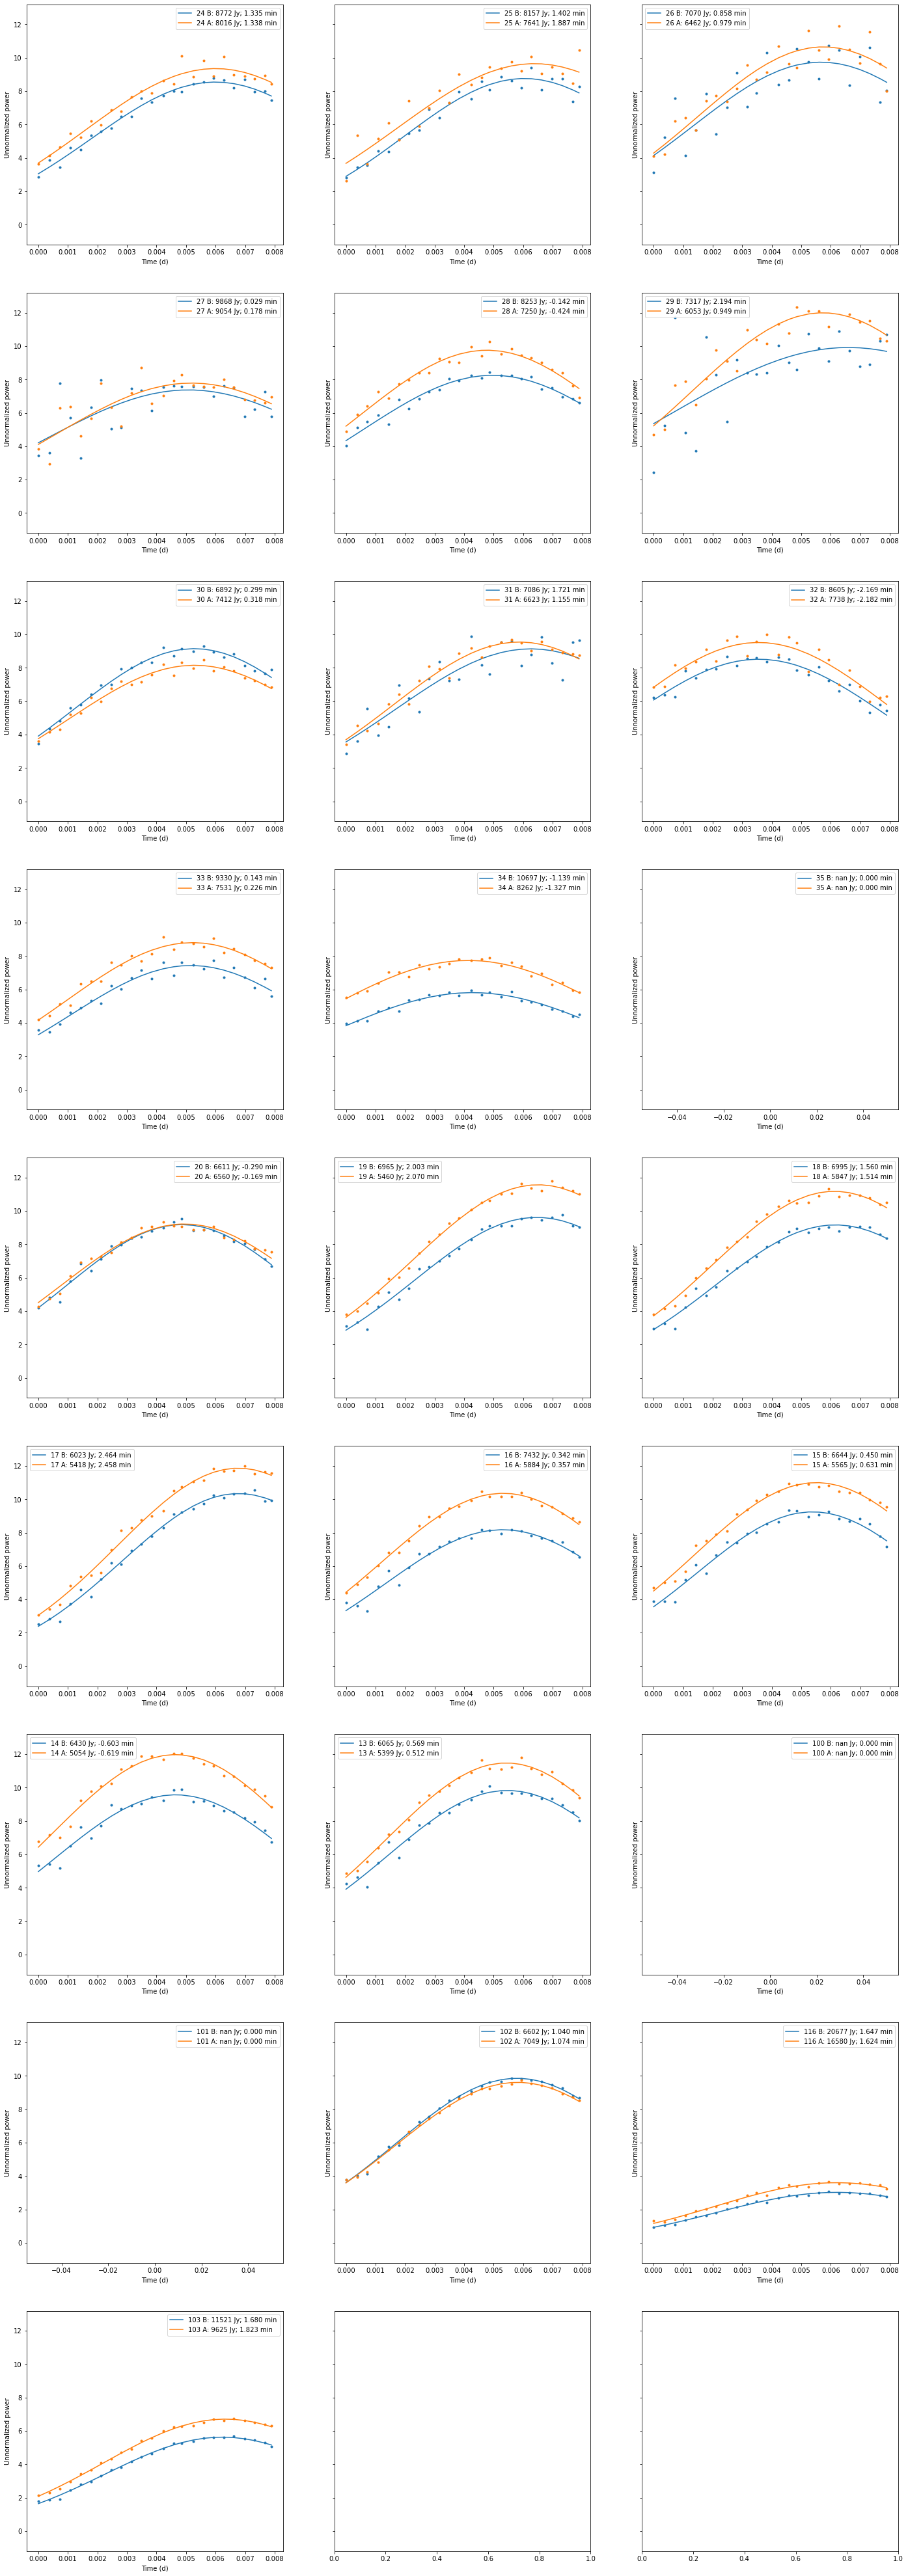

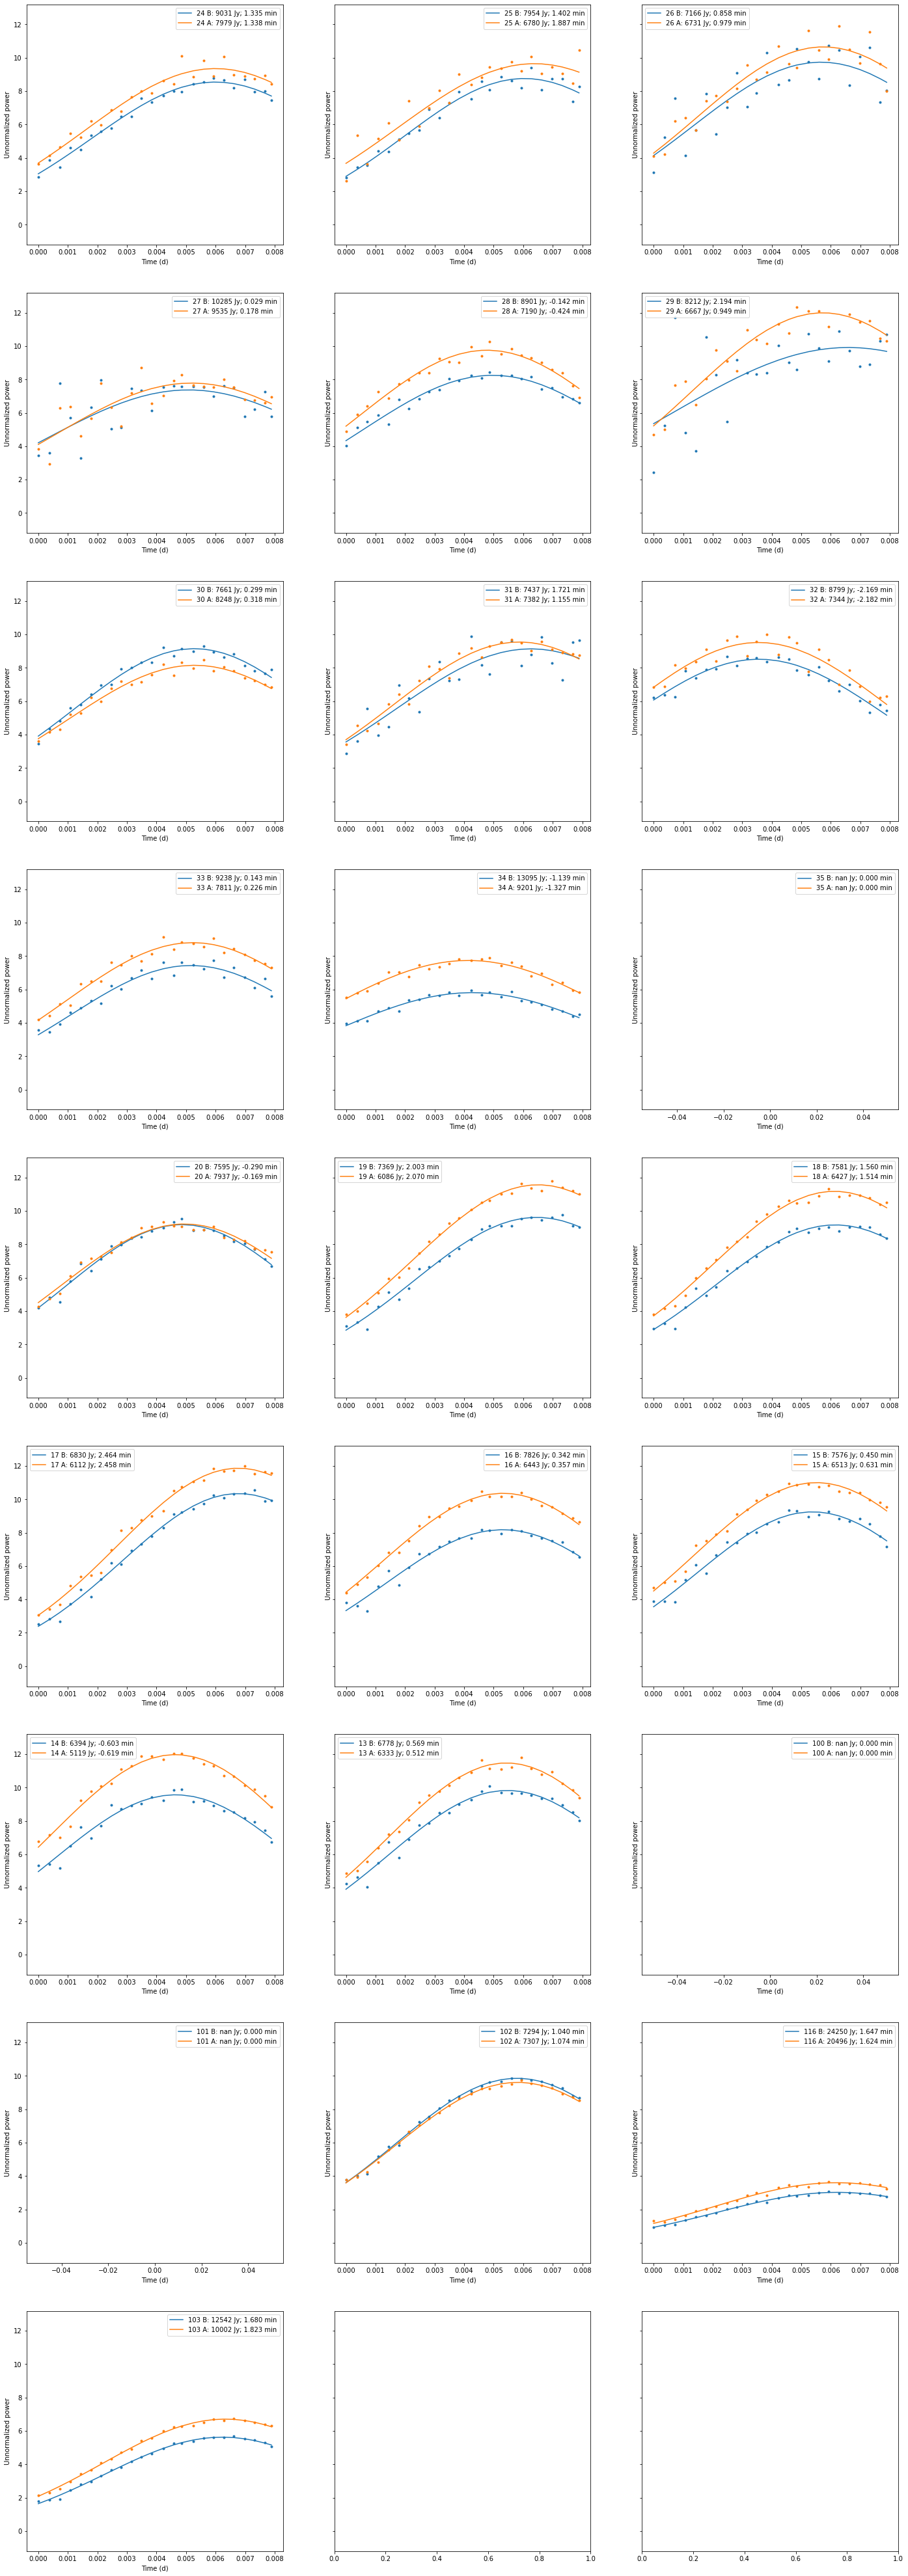

In [118]:
nbin = fobs.shape[0]//4
all_sefds = np.zeros((25, 4, 2))
frefs = np.zeros(4)
for i in range(4):
    print(i)
    antennas, sefds, gains, transit_times, fref, hwhm = calculate_sefd(
        msname,
        filenames[date][calname]['cal'],
        showplots=True,
        halfpower=True,
        fmin=fobs[nbin*i],
        fmax=fobs[nbin*(i+1)-1]
    )
    frefs[i] = fref
    all_sefds[:, i, :] = sefds

In [119]:
      np.savez(
            './sefds/{0}_{1}_v2'.format(date, calname),
            sefds=all_sefds,
            frefs=fref
        )

In [120]:
ls ./sefds

2021-04-13_J052109+163822.npz  2021-04-13_J052109+163822_v2.npz


In [121]:
all_sefds.shape

(25, 4, 2)